### 資料預處裡

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import pickle
from bisect import bisect_left

pd.set_option('display.max_columns', None)

In [2]:
col_to_pick = ['airline',
               'airport_depa',
               'airport_dest',
               'month_actu_depa',
               'day_actu_depa',
               'hr_actu_depa',
               'min_actu_depa',
               'month_actu_dest',
               'day_actu_dest',
               'hr_actu_dest',
               'min_actu_dest',
               'actu_duration',
               'dry_bulb_temp_dest',
               'precipitation_dest',
               'snow_fall_dest',
               'relative_humidity_dest',
               'wind_speed_dest',
               'pressure_dest',
               'visibility_dest',
               'delay_dest']

In [3]:
df = pd.read_csv('../data/US_1722_flights_dataset_v1_IQR_ML.csv', usecols=col_to_pick)
df.shape

(28926859, 20)

In [4]:
# 進行【航空公司】頻率編碼
freq = df['airline'].value_counts(normalize=True)
df['airline_freq'] = df['airline'].map(freq)

# 進行【出發機場】頻率編碼
freq = df['airport_depa'].value_counts(normalize=True)
df['airport_depa_freq'] = df['airport_depa'].map(freq)

# 進行【抵達機場】頻率編碼
freq = df['airport_dest'].value_counts(normalize=True)
df['airport_dest_freq'] = df['airport_dest'].map(freq)

# 【延誤時長】轉整數
df['delay_dest'] = df['delay_dest'].astype(int)

# 【飛行時長】轉整數
df['actu_duration'] = df['actu_duration'].astype(int)

# 【風速】轉整數
df['wind_speed_dest'] = df['wind_speed_dest'].astype(int)

# 【能見度】轉整數
df['visibility_dest'] = df['visibility_dest'].astype(int)

# 【氣壓】轉小數後2位
df['pressure_dest'] = df['pressure_dest'].round(2)

In [5]:
# # 取得頻率編碼表
# df_airline = df[['airline', 'airline_freq']]
# df_airline = df_airline.drop_duplicates(subset=['airline_freq'], keep='first')
# df_airline = df_airline.sort_values(by='airline_freq').reset_index(drop=True)
# airline_freq = {k:v for k, v in zip(df_airline.iloc[:, 0], df_airline.iloc[:, 1])}

# df_airport_depa = df[['airport_depa', 'airport_depa_freq']]
# df_airport_depa = df_airport_depa.drop_duplicates(subset=['airport_depa_freq'], keep='first')
# df_airport_depa = df_airport_depa.sort_values(by='airport_depa_freq').reset_index(drop=True)
# airport_depa_freq = {k:v for k, v in zip(df_airport_depa.iloc[:, 0], df_airport_depa.iloc[:, 1])}

# df_airport_dest = df[['airport_dest', 'airport_dest_freq']]
# df_airport_dest = df_airport_dest.drop_duplicates(subset=['airport_dest_freq'], keep='first')
# df_airport_dest = df_airport_dest.sort_values(by='airport_dest_freq').reset_index(drop=True)
# airport_dest_freq = {k:v for k, v in zip(df_airport_dest.iloc[:, 0], df_airport_dest.iloc[:, 1])}

# # 將字典轉換為JSON格式並保存到文件中
# with open('../json/airline_freq.json', 'w') as i:
#     json.dump(airline_freq, i)
# with open('../json/airport_depa_freq.json', 'w') as j:
#     json.dump(airport_depa_freq, j)
# with open('../json/airport_dest_freq.json', 'w') as k:
#     json.dump(airport_dest_freq, k)

                     airline
delay_dest_classes          
0                    1093699
1                    8062424
2                   13269893
3                    5073397
4                    1243705
5                     183741


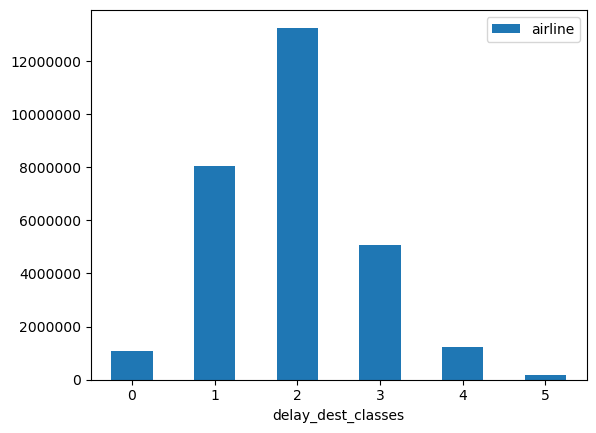

In [7]:
# # 定義將數值欄位進行分類的方法
# def delay_minutes_to_classes(x: float, intervals: tuple[float, ...]=(-30, -15, 0, 15, 30,)) -> int:
#     return bisect_left(intervals, x)

# # 對 delay_dest 進行分類編碼
# df['delay_dest_classes'] = df['delay_dest'].apply(delay_minutes_to_classes)

# 檢視各類別數據量
df[['delay_dest_classes', 'airline']].groupby('delay_dest_classes').count().plot(kind='bar', rot=0)
plt.ticklabel_format(style='plain',
                     axis='y')
print(df[['delay_dest_classes', 'airline']].groupby('delay_dest_classes').count())

In [7]:
# # 測試方法是否有效
# def test_delay_minutes_to_classes():
#     for i, x in enumerate(np.arange(-47, 60, 15)):
#         assert i == delay_minutes_to_classes(x)

# tmp = df["delay_dest"].apply(delay_minutes_to_classes)
# pd.concat((tmp, df["delay_dest"]), axis=1).head(10)

# t = tmp.to_frame()
# t["index"] = range(len(t))
# print(t.groupby("delay_dest").count())
# t.groupby("delay_dest").count().plot(kind='bar', rot=0)

                     airline
delay_dest_classes          
0                    9156123
1                   13269893
2                    5073397
3                    1427446


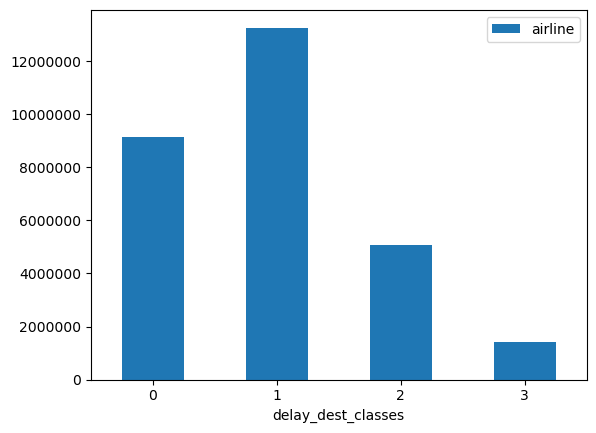

In [8]:
# 定義將數值欄位進行分類的方法
def delay_minutes_to_classes(x: float, intervals: tuple[float, ...]=(-15, 0, 15,)) -> int:
    return bisect_left(intervals, x)

# 對 delay_dest 進行分類編碼
df['delay_dest_classes'] = df['delay_dest'].apply(delay_minutes_to_classes)

# 檢視各類別數據量
df[['delay_dest_classes', 'airline']].groupby('delay_dest_classes').count().plot(kind='bar', rot=0)
plt.ticklabel_format(style='plain',
                     axis='y')
print(df[['delay_dest_classes', 'airline']].groupby('delay_dest_classes').count())

In [9]:
# df.to_csv('../data/BeOnTime_full.csv', index=False)
# df.shape

### 增加資料量

                     airline
delay_dest_classes          
0                    9156123
1                   13269893
2                   10146794
3                    9992122


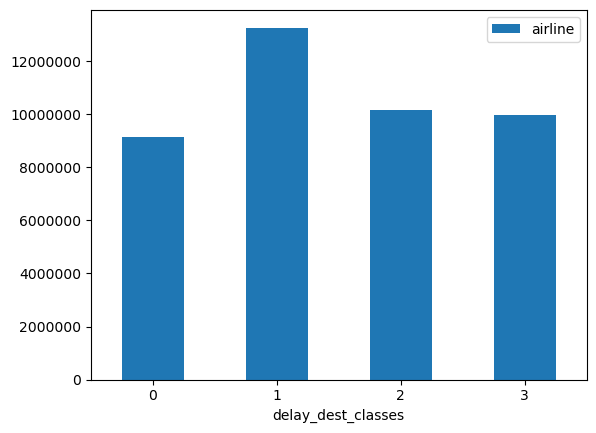

In [10]:
# # 增加類別【2】的 data 量，用`loc`方法選擇符合條件的資料
# delay_dest_classes_2 = df.loc[df['delay_dest_classes'] == 2].copy()
# # 複製 1 倍
# delay_dest_classes_2 = pd.concat([delay_dest_classes_2] * 1)
# # 將複製的資料和原始DataFrame合併回同一份DataFrame中
# df = pd.concat([df, delay_dest_classes_2], ignore_index=True)


# # 增加類別【3】的 data 量，用`loc`方法選擇符合條件的資料
# delay_dest_classes_3 = df.loc[df['delay_dest_classes'] == 3].copy()
# # 複製 6 倍
# delay_dest_classes_3 = pd.concat([delay_dest_classes_3] * 6)
# # 將複製的資料和原始DataFrame合併回同一份DataFrame中
# df = pd.concat([df, delay_dest_classes_3], ignore_index=True)


# 檢視各類別數據量
df[['delay_dest_classes', 'airline']].groupby('delay_dest_classes').count().plot(kind='bar', rot=0)
plt.ticklabel_format(style='plain',
                     axis='y')
print(df[['delay_dest_classes', 'airline']].groupby('delay_dest_classes').count())

In [11]:
# df.to_csv('../data/BeOnTime_full_addData.csv', index=False)
# df.shape

(42564932, 24)

### 切分 train、val、test (每個類別都平均切分)

In [11]:
# # 將類別進行排序
# sorted_data = df.sort_values('delay_dest_classes')
# # 根據類別欄位進行分組
# grouped_data = sorted_data.groupby('delay_dest_classes')


# # 計算每個類別的樣本數
# counts = grouped_data.size()
# # 計算總樣本數
# total_count = counts.sum()
# # 計算訓練集應該包含的樣本數
# train_count = int(total_count * 0.6)
# # 計算驗證集應該包含的樣本數
# val_count = int(total_count * 0.2)
# # 計算測試集應該包含的樣本數
# test_count = total_count - train_count - val_count


# # 隨機分配樣本到訓練集、驗證集和測試集中
# train_data = pd.DataFrame()
# val_data = pd.DataFrame()
# test_data = pd.DataFrame()
# for name, group in grouped_data:
#     # 從每個類別的子資料集中隨機取出樣本
#     train_sample = group.sample(n=train_count, replace=True)
#     # 使用了 `replace=True 的參數，以保證每個類別在訓練集、驗證集和測試集中的樣本數是相等的。當某個類別的樣本數不足時，replace=True` 會允許重複取樣本，直到達到指定的數量。
#     val_sample = group.drop(train_sample.index).sample(n=val_count, replace=True)
#     test_sample = group.drop(train_sample.index).drop(val_sample.index)
#     # 將取出的樣本合併到對應的資料集中
#     train_data = pd.concat([train_data, train_sample])
#     val_data = pd.concat([val_data, val_sample])
#     test_data = pd.concat([test_data, test_sample])


# train_data.to_csv('../data/BeOnTime_train_weight.csv', index=False)
# val_data.to_csv('../data/BeOnTime_val_weight.csv', index=False)
# test_data.to_csv('../data/BeOnTime_test_weight.csv', index=False)